In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, DistilBertModel, AlbertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, hamming_loss, classification_report
from skmultilearn.model_selection import iterative_train_test_split
import seaborn as sns
import re
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

/Users/anna-alexandradanchenko/local/JobTitleClassification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Exploratory Data Analysis
### Import Data

In [3]:
job_level_data = pd.read_excel("data/JobLevelData.xlsx")
job_level_data

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN
...,...,...,...,...,...
2235,Net Software Architect and Team Project Lead,Manager,NaN,NaN,NaN
2236,Solutions Architect & Technical Lead,Manager,Individual Contributor/Staff,NaN,NaN
2237,"Manager, Salesforcecom Administration and Rele...",Manager,NaN,NaN,NaN
2238,Innovation Automation Architect,Manager,NaN,NaN,NaN


### Handling Missing Data

Let's identify rows where all target columns are NaN, meaning no label is assigned to the position title.

Upon analysis, there are 10 rows without labels, representing only 0.4% of the data. Since this is a very small percentage, several actions could be taken to handle these rows:

- **Manual Labeling**. Given the small number of entries, it might be possible to ask the data provider or client to label them manually. However, for now we don't have direct communication with the client and also lack sufficient knowledge of the data's context to label them accurately ourselves.
- **Data Imputation**. There are several possible variants of imputation: 

    -  **Fill with default values, e.g. "Unknown"**. Not good approach, as introducing a new class may confuse the model and reduce the quality of predictions.
    - **Predictive Imputation**. Might be an overkill for this size of data. 

- **Removing the rows with missing data**. Removing NaN rows may be a reasonable solution, as it would likely have little impact on model performance.

In [4]:
nan_rows = job_level_data[job_level_data.drop(columns=['Title']).isna().all(axis=1)]
print(f"Percentage of not labeled data: {len(nan_rows) / len(job_level_data) * 100}")
nan_rows

Percentage of not labeled data: 0.4464285714285714


,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


It was decided to remove the rows with missing data.

In [5]:
job_level_data.drop(nan_rows.index, inplace=True)

### Merging Label Columns into a List

To simplify the manipulation of label data and make it suitable for model input, we need to combine the values from multiple columns into a single list.

In [6]:
job_level_data["Label"] = job_level_data.drop(columns=["Title"]).values.tolist()
job_level_data.drop(columns=["Column 1", "Column 2", "Column 3", "Column 4"], inplace=True)

def remove_nans_from_array(list):
    return [label for label in list if not pd.isna(label)]

job_level_data["Label"] = job_level_data["Label"].apply(remove_nans_from_array)
job_level_data["Label"] = job_level_data["Label"].apply(lambda labels: sorted(labels))

job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
2,"Executive Director, Global IT Infrastructure /...","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
4,"Vice President, CIO",[Vice President]
...,...,...
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Rele...",[Manager]
2238,Innovation Automation Architect,[Manager]


### Distribution of Labels

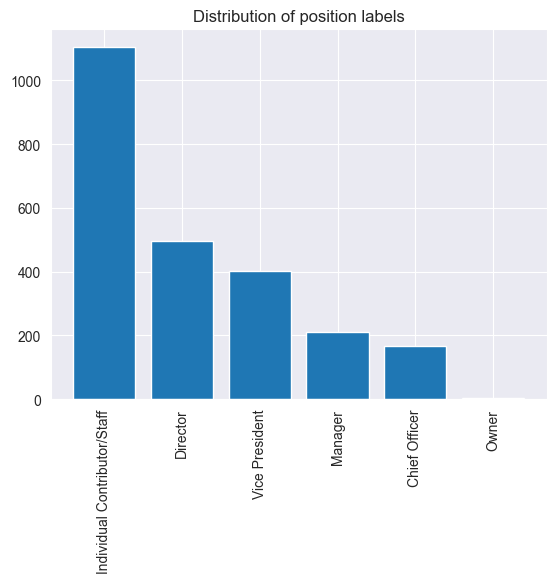

In [7]:
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)
labels_count_keys, labels_count_values = zip(*labels_count)

fig, ax = plt.subplots()
ax.bar(labels_count_keys, labels_count_values)
ax.set_title('Distribution of position labels')
plt.xticks(rotation=90) 

plt.show()

It can be observed from the distribution, the data is highly imbalanced, with "Owner" label being highly under respresented. This imbalance requires further attention during model training and evaluation.

### "Owner" Label Exploration

In [8]:
owner_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Owner" in labels)]
owner_label_entries

,Title,Label
22,CoFounder & CTO,"[Chief Officer, Owner]"
119,"Chief Operating Officer, Co-Founder","[Chief Officer, Owner]"
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1933,"Founder, COO","[Chief Officer, Owner]"


As can be observed from the data, there is only 4 entries labeled as "Owner". This is insufficient for effectively training a machine learning model, especially for creating an adequate train-test split.

To address this, we can check if we can assign the "Owner" label based on whether the title contains keywords like "Owner" or "Founder" during the model inference.  

In [9]:
job_level_data[job_level_data["Title"].apply(lambda title: "Owner" in title)]

,Title,Label
30,Owner & Data Architect,"[Chief Officer, Manager]"
896,"Senior Manager Product Owner, Wireless Expansi...","[Director, Manager, Vice President]"
998,Co-Owner & Marketing Manager,"[Chief Officer, Manager]"
1054,Practice Owner,[Individual Contributor/Staff]
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1481,In App Learning Owner Software,[Individual Contributor/Staff]
1566,Owner Services Coordinator,[Individual Contributor/Staff]
1632,Owner / Franchisee,[Chief Officer]
1828,Senior Software Consultant / Product Owner,[Individual Contributor/Staff]
1847,"Product Owner Digital, Data and IS Direction",[Manager]


Inspecting data above, it was found that not all titles containing the words "Owner" or "Founder" are labeled as "Owner." This suggests that making a decision to hard-code labelling of this category would be unreliable. 

In conclusion, the "Owner" label may not be predictable given the data currently available. As there are usually only a few owners of the company, it would be better to label the data manually on top of models prediction. Therefore, we will remove the entries with the "Owner" label.

In [10]:
job_level_data.drop(owner_label_entries.index, inplace=True)

# update labels list and count for further usage
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)

### "Manager" Label Exploration
The baseline model yields a high number of false negatives for the "Manager" label, failing to predict it correctly. Let's explore the data to understand why this is happening .

In [11]:
manager_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Manager" in labels)]
manager_label_entries

,Title,Label
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
14,"Lead Software Engineer, Technical Team Lead","[Individual Contributor/Staff, Manager]"
30,Owner & Data Architect,"[Chief Officer, Manager]"
32,CEO/Solution Architect,"[Chief Officer, Manager]"
34,Cloud Architect | DevOps Engineer | Tech Lead,"[Individual Contributor/Staff, Manager]"
...,...,...
2234,"Solution Architect, Technical Account Manager",[Manager]
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Rele...",[Manager]


### "Chief Officer" Label Exploration
The baseline model yields a high number of false negatives for the "Manager" label, failing to predict it correctly. Let's explore the data to understand why this is happening.

In [12]:
manager_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Chief Officer" in labels)]
manager_label_entries

,Title,Label
2,"Executive Director, Global IT Infrastructure /...","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
5,"CIO, Cissp",[Chief Officer]
6,"Chief Information Officer, Platform Services",[Chief Officer]
7,Chief Technology Officer / Head Of Marketing,[Chief Officer]
...,...,...
2157,Audit and TAS Partner Chairman and CEO,[Chief Officer]
2187,Chief Marketing & Revenue Officer,[Chief Officer]
2228,"Vice President, CIO Global Business Services",[Chief Officer]
2233,"Chief Information Security Officer, AVP Inform...",[Chief Officer]


### Label One-Hot Encoding

In [13]:
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(job_level_data["Label"])
one_hot_df = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
job_level_data["Label"] = one_hot_df.values.tolist()

classes_labels = mlb.classes_
print(classes_labels)
job_level_data

['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Vice President']


,Title,Label
0,Vice President / Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer; Systems Architect,"[0, 0, 1, 1, 0]"
2,"Executive Director, Global IT Infrastructure /...","[1, 1, 0, 0, 0]"
3,CTO/Executive Director of Technology Services,"[1, 1, 0, 0, 0]"
4,"Vice President, CIO","[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect & Technical Lead,"[0, 0, 1, 1, 0]"
2237,"Manager, Salesforcecom Administration and Rele...","[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


### Correlation Matrix
The following observations can be made from the correlation matrix:
- Majority of correlations are negative or 0, meaning that there is low overlap between roles. 
- The correlation matrix shows a hierarchy in the company, with lower hierarchy positions such as "Individual Contributor/Staff" having strong negative correlations with senior titles like "Director"(-0.5), "Vice President"(-0.44) and Chief Officer(-0.27). The model will rather think of them as mutually exclusive.

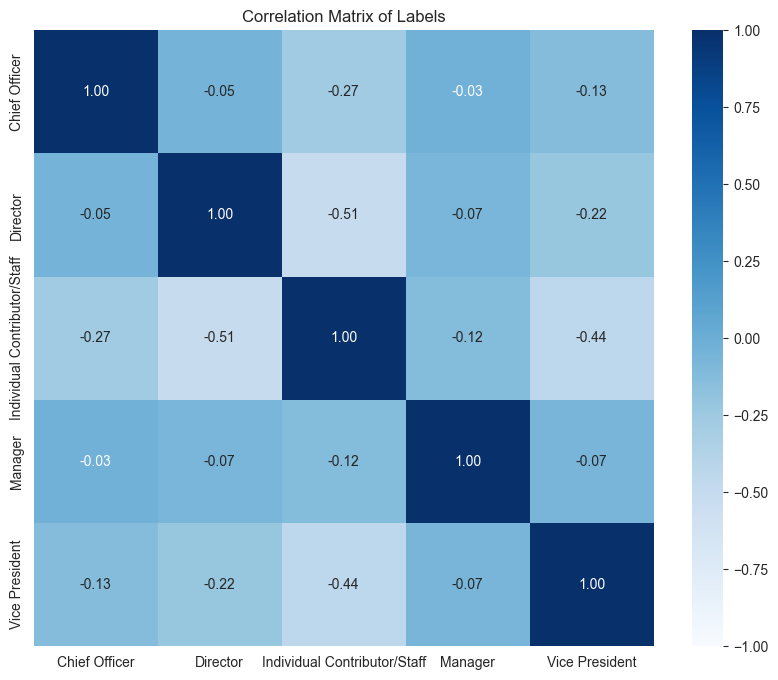

In [14]:
correlation_matrix = one_hot_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Labels')
plt.show()

### Text Preprocessing
- Removing punctiation and any special characters
- Normalizing whitespaces

In [15]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

job_level_data["Title"] = job_level_data["Title"].apply(preprocess_text)
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global IT Infrastructure Ch...,"[1, 1, 0, 0, 0]"
3,CTO Executive Director of Technology Services,"[1, 1, 0, 0, 0]"
4,Vice President CIO,"[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2237,Manager Salesforcecom Administration and Relea...,"[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


As BERT tokenizer might separate acronyms, therefore it is highly beneficial to expand them to their full form. 

In [16]:
acronyms_dict = {
    "ceo": "Chief Executive Officer",
    "cfo": "Chief Financial Officer",
    "cto": "Chief Technology Officer",
    "vp": "Vice President",
    "hr": "Human Resources",
    "chro": "Chief Human Resources Officer",
    "cio": "Chief Information Officer",
    "ciso": "Chief Information Security Officer",
    "clo": "Chief Legal Officer",
    "cmo": "Chief Marketing Officer",
    "coo": "Chief Operating Officer",
    "cino": "Chief Innovation Officer",
    "cpo": "Chief Product Officer",
    "cro": "Chief Revenue Officer",
    "evp": "Executive Vice President",
    "svp": "Senior Vice President",
    "it": "Informational Technology"
}

def expand_acronyms(text):
    words = text.split()
    expanded_words = [acronyms_dict.get(word.lower(), word) for word in words]
    return ' '.join(expanded_words)

job_level_data["Title"] = job_level_data["Title"].apply(expand_acronyms)
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global Informational Techno...,"[1, 1, 0, 0, 0]"
3,Chief Technology Officer Executive Director of...,"[1, 1, 0, 0, 0]"
4,Vice President Chief Information Officer,"[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2237,Manager Salesforcecom Administration and Relea...,"[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


We do not perform any other preprocessing steps, such as stemming or lemmatization, as the BERT model is designed to understand textual data in context.

### Tokenization
Cased BERT model will be used to tokenize the data (wordpiece algorithm). The cased model was chosen as the data contains abbreviations which are case-sensitive.

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [18]:
def split_text(text):
    return tokenizer.tokenize(text)

max_len = job_level_data["Title"].apply(split_text).apply(len).max()
print("Maximum lengths of tokenized sentence: ", max_len)

Maximum lengths of tokenized sentence:  21


## Dataset Loading

In [19]:
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 64
MAX_EPOCHS = 50
EARLY_STOPPING_PAT = 4
THRESHOLD = 0.5

In [20]:
# handle input data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'].flatten(),
            'attention_mask': encoded_data['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split

In [21]:
# TODO: implement stratification
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1780,)
Test data: (446,)


In [22]:
train_dataset = JobTitlesDataset(
    titles=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = JobTitlesDataset(
    titles=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Model Definition and Training

BERT model is considered a  many text classification problems. distilBERT model was chosen as the model for this task due to its strong performance in understanding textual data and lower complexity than the base-bert model. While the model is computationally expensive, it is able to capture different nuances in the data, such as misspelings, not expanded abbreviations, etc. 

However, it is fully aknowledged that it is probably not the best solution due to it's training time and model size, which comprises around MB. Given the nature of data (small sentences), the perfect approach would be to establish a baseline model with simpler architecture and then compare the BERT model to it, for example TF-IDF with Logistic Regression. 

Another approach that would be worth trying is using a hybrid approach, where BERT is used for embeddings and then fed into a simpler model.

In [23]:
class JobTitleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(JobTitleClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-cased') # pre-trained bert model
        self.dropout = torch.nn.Dropout(0.5) # regularization
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.last_hidden_state[:, 0, :])
        output = self.linear(output)
        return output

model_bert_classifier = JobTitleClassifier(len(mlb.classes_)).to(device)

In [24]:
total_positives = sum(count for label, count in labels_count)
class_weights = [total_positives / count for label, count in labels_count]

class_weights = np.array(class_weights)
class_weights = class_weights * (len(class_weights) / class_weights.sum())
class_weights = torch.FloatTensor(class_weights).to(device)

class_weights

tensor([0.2781, 0.6182, 0.7624, 1.4562, 1.8850], device='mps:0')

In [25]:
adam_optimizer = torch.optim.AdamW(model_bert_classifier.parameters(), lr=2e-5)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=class_weights) # includes sigmoid activation
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', patience=2, factor=0.2)

In [26]:
def train_classifier(model,
                     data_loader,
                     loss_fn,
                     optimizer,
                     device):
    model = model.train()
    losses = []

    for batch_num, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        true_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, true_labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(losses)


In [27]:
def validation(model,
               data_loader,
               loss_fn,
               device):
    model = model.eval()
    losses = []
    predictions = []
    targets = []

    # ensures no gradients are computed during test mode
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            eval_loss = loss_fn(outputs, true_labels).item()
            losses.append(eval_loss)

            preds = torch.sigmoid(outputs)
            predictions.extend(preds.cpu().numpy())
            targets.extend(true_labels.cpu().numpy())

    return np.mean(losses), predictions, targets

### Training and Evaluation Process
According to [Correlation analysis of performance measures for multi-label classification (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0306457318300165), these are the most widely-used performance measures for multi-label classification:
- **Hamming Loss**: the most recommended due to its lack of correlation with other measures (avoiding redundancy) and being the most employed in literature at the time of paper writing.
- **F1 and Accuracy**: have strong correlation with other metrics, making them representative measures that reduce the need to report multiple similar metrics.



In [28]:
train_losses = []
val_losses = []

hamming_loss_scores = []
f1_scores = []
accuracy_scores = []

best_loss = float('inf')
best_model_weights = None
best_predictions = None
best_targets = None
patience = EARLY_STOPPING_PAT

for epoch in range(MAX_EPOCHS):
    print(f'Epoch {epoch + 1}')

    # Training
    train_loss = train_classifier(model_bert_classifier, train_loader, bce_loss, adam_optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss, predictions, targets = validation(model_bert_classifier, test_loader, bce_loss, device)
    val_losses.append(val_loss)

    # Update learning rate
    plateau_scheduler.step(val_loss)
    print(f"Current learning rate: {adam_optimizer.param_groups[0]['lr']}")

    predictions = np.array(predictions) >= THRESHOLD
    targets = np.array(targets)

    print(f"Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}")

    accuracy = accuracy_score(targets, predictions)
    print(f"Accuracy: {accuracy:.5f}")

    f1 = f1_score(targets, predictions, average='macro', zero_division=1)
    print(f"F1: {f1:.5f}")

    hamming_loss_score = hamming_loss(targets, predictions)
    print(f"Hamming Loss: {hamming_loss_score:.5f}")

    hamming_loss_scores.append(hamming_loss_score)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model_bert_classifier.state_dict())
        best_predictions = predictions.copy()
        best_targets = targets.copy()
        patience = EARLY_STOPPING_PAT 
    else:
        patience -= 1
        if patience == 0:
            break

    print("\n")
    
model_bert_classifier.load_state_dict(best_model_weights)

Epoch 1
Current learning rate: 2e-05
Training loss: 0.45296, Validation loss: 0.27838
Accuracy: 0.60090
F1: 0.34625
Hamming Loss: 0.11480


Epoch 2
Current learning rate: 2e-05
Training loss: 0.22416, Validation loss: 0.18069
Accuracy: 0.79821
F1: 0.55287
Hamming Loss: 0.06547


Epoch 3
Current learning rate: 2e-05
Training loss: 0.14973, Validation loss: 0.14323
Accuracy: 0.82960
F1: 0.68046
Hamming Loss: 0.05247


Epoch 4
Current learning rate: 2e-05
Training loss: 0.11508, Validation loss: 0.14176
Accuracy: 0.84529
F1: 0.76977
Hamming Loss: 0.04888


Epoch 5
Current learning rate: 2e-05
Training loss: 0.10109, Validation loss: 0.14917
Accuracy: 0.83184
F1: 0.80235
Hamming Loss: 0.05202


Epoch 6
Current learning rate: 2e-05
Training loss: 0.09073, Validation loss: 0.12911
Accuracy: 0.86547
F1: 0.84100
Hamming Loss: 0.04215


Epoch 7
Current learning rate: 2e-05
Training loss: 0.07283, Validation loss: 0.13140
Accuracy: 0.86547
F1: 0.82871
Hamming Loss: 0.04395


Epoch 8
Current lear

<All keys matched successfully>

In [29]:
torch.save(model_bert_classifier.state_dict(), 'models/job_title_classification_model.pth')

## Results Interpretation

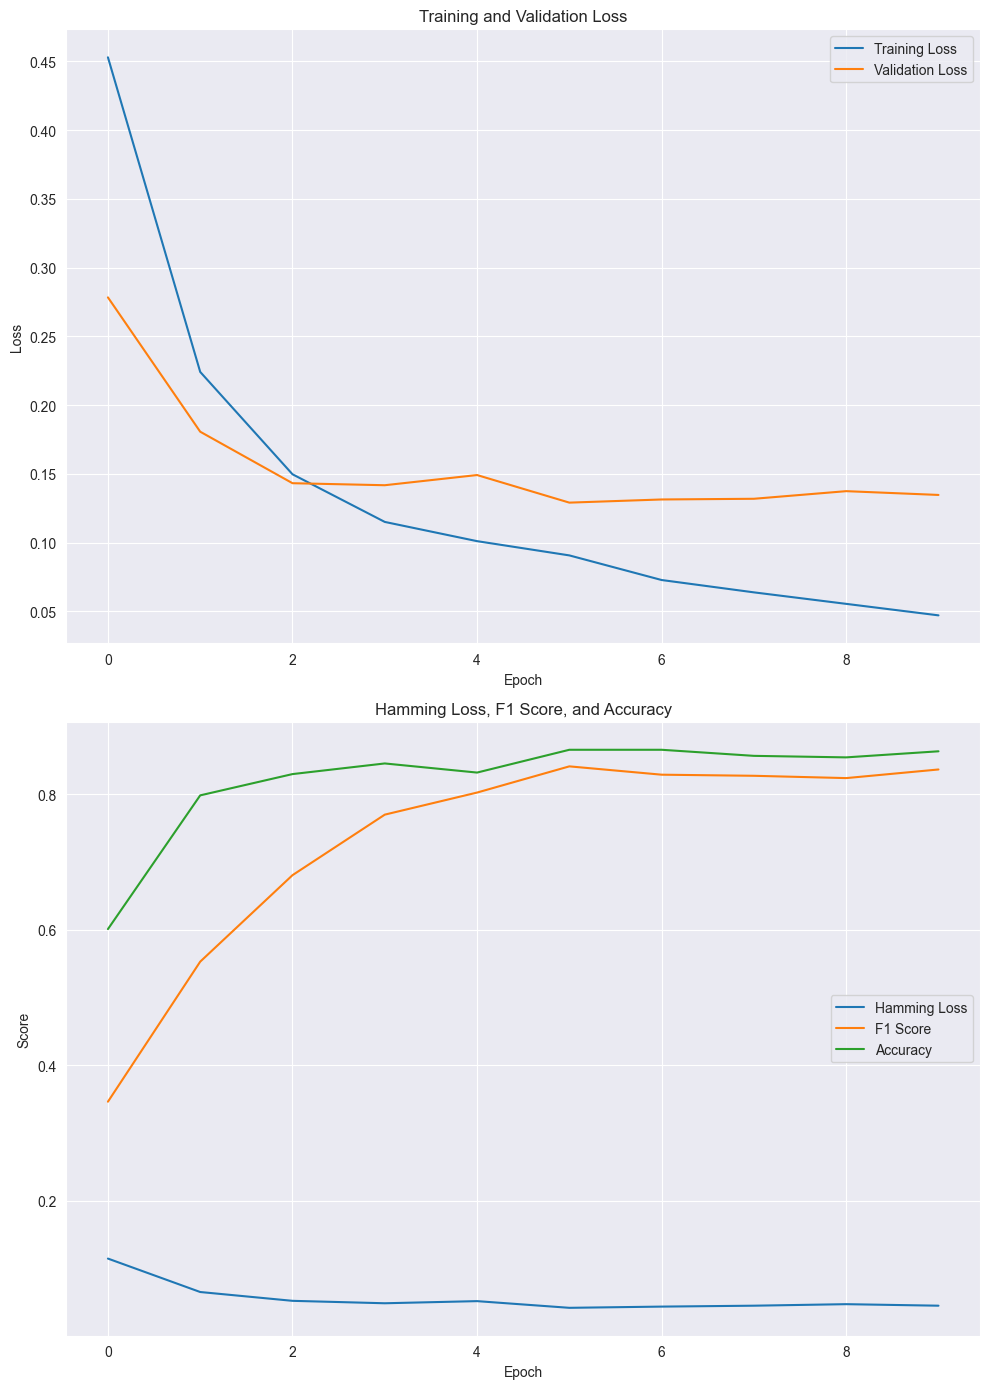

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(hamming_loss_scores, label='Hamming Loss')
ax2.plot(f1_scores, label='F1 Score')
ax2.plot(accuracy_scores, label='Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('Hamming Loss, F1 Score, and Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

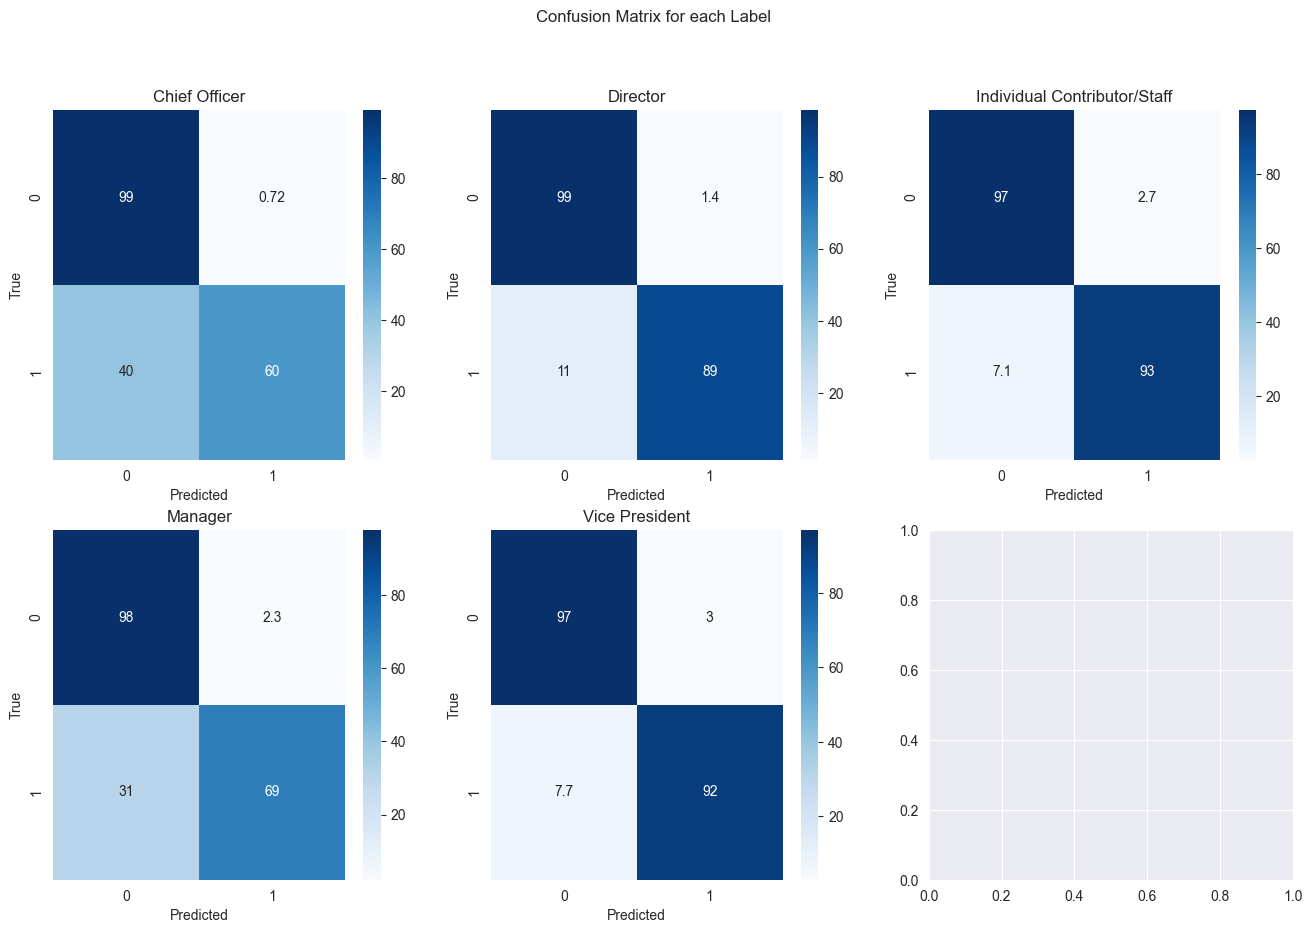

In [31]:
cm = multilabel_confusion_matrix(np.array(best_targets), np.array(best_predictions))

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])
""
plt.show()

In [32]:
report = classification_report(best_targets, best_predictions, target_names=classes_labels, zero_division=1)
print(report)

                              precision    recall  f1-score   support

               Chief Officer       0.86      0.60      0.71        30
                    Director       0.95      0.89      0.92        98
Individual Contributor/Staff       0.97      0.93      0.95       224
                     Manager       0.79      0.69      0.74        49
              Vice President       0.87      0.92      0.89        78

                   micro avg       0.92      0.87      0.90       479
                   macro avg       0.89      0.81      0.84       479
                weighted avg       0.92      0.87      0.90       479
                 samples avg       0.93      0.90      0.90       479

